## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.heatmap_analysis as heatmap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.create_weblogos import save_web_logo_alignment

2023-02-24 11:30:09.899056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 11:30:18.116011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fontconfig warning: ignoring UTF-8: not a valid regio

## Load the pre-trained model

In [2]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")

protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)


(
    (
        X_train,
        X_test,
        mdm2_y_train,
        mdm2_y_test,
        mdm2_y_raw_train,
        mdm2_y_raw_test,
        ca5_y_train,
        ca5_y_test,
        ca5_y_raw_train,
        ca5_y_raw_test,
        peptides_train,
        peptides_test,
    ),
    results,
) = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X,
    mdm2_y,
    rnn.Joint_BinaryClassificationRNN_gelu,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    load_trained_model=True,
    model_save_name='mdm2_bilstm_best.h5',
    other_datasets=[
        mdm2_y_raw,
        ca5_y,
        ca5_y_raw,
        peptides,
    ],
)
mdm2_model = results.trained_model
mdm2_y_pred_raw = mdm2_model(X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5


def ca5_model(x):
    ca5_pred_raw = mdm2_model(x).numpy()
    ca5_pred_raw[:, 1] = 1 - ca5_pred_raw[:, 1]
    return ca5_pred_raw


ca5_y_pred_raw = ca5_model(X_test)
ca5_y_pred = ca5_y_pred_raw > 0.5

print("MDM2")
evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)
print("12ca5")
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred)

/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is -0.6565247891915524
MDM2
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.8765533028122956
	 recall:  0.9933296275708727
	 # neg predictions:  467
	 # pos predictions:  6116
12ca5
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.9229122055674518
	 recall:  0.3634064080944351
	 # neg predictions:  6116
	 # pos predictions:  467


## 12ca5 Heatmaps From Ground Truth Good Sequences (No Model Training)

<AxesSubplot: >

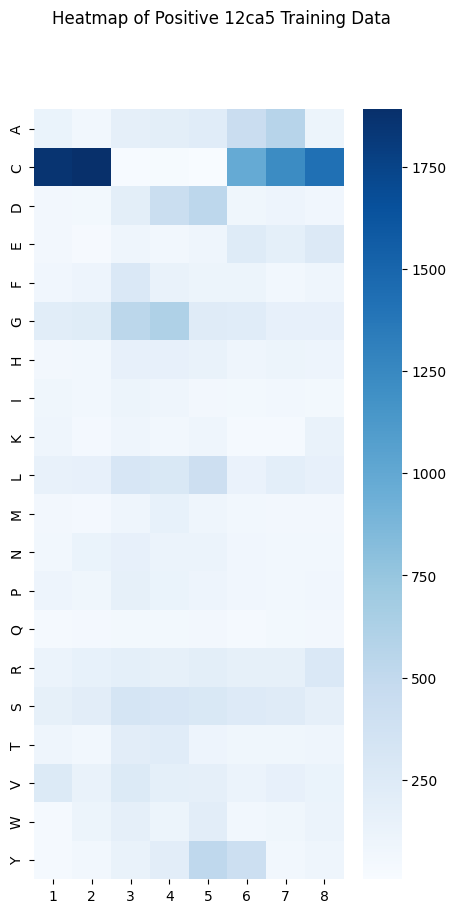

In [3]:
# TODO(Yehlin): WHy are we using the training dataset?
# Perhaps best to use either the full of the test dataset.
ca5_true_training_data_peptides = np.array(
    [peptide for idx, peptide in enumerate(peptides_train) if ca5_y_train[idx].all()]
)

heatmap.generate_heatmap(
    ca5_true_training_data_peptides, title="Heatmap of Positive 12ca5 Training Data"
)

In [4]:
# Dict_3mer_occ = {}
# for tmer in initialize_Proc2Vec_embeddings().keys():
#     tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
#     tmer_occ = np.array(tmer_good_seqs).sum()
#     Dict_3mer_occ[tmer] = tmer_occ

# sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
# sorted_x[-15:]
# print(sorted_x[-1])
# print(sorted_x[-2])
# print(sorted_x[-3])
# print(sorted_x[-4])
# print(sorted_x[-5])

## MDM2 vs 12ca5 From Ground Truth Good Sequences (No Model Training)

<AxesSubplot: >

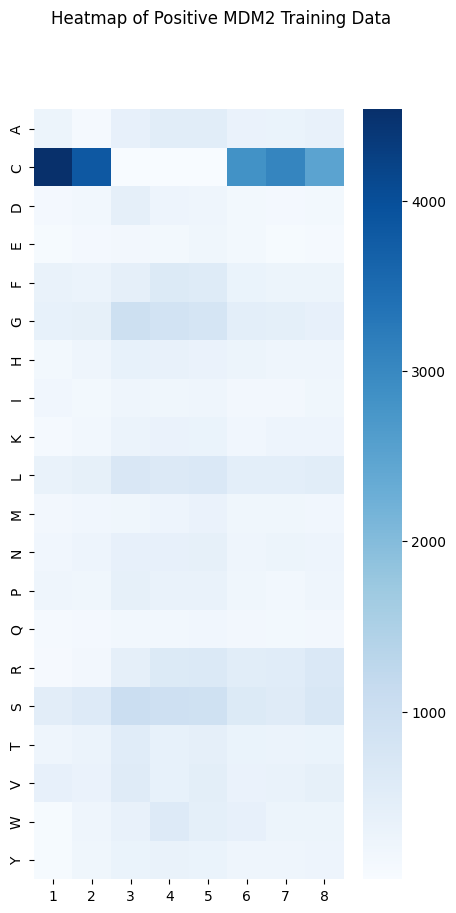

In [5]:
# TODO(Yehlin): WHy are we using the training dataset?
# Perhaps best to use either the full of the test dataset.
mdm2_true_training_data_peptides = np.array(
    [peptide for idx, peptide in enumerate(peptides_train) if mdm2_y_train[idx].all()]
)
heatmap.generate_heatmap(
    mdm2_true_training_data_peptides, title="Heatmap of Positive MDM2 Training Data"
)

In [6]:
# Dict_3mer_occ = {}
# for tmer in initialize_Proc2Vec_embeddings().keys():
#     tmer_good_seqs = [find_3mer(seq, tmer) for seq in mdm2_true_training_data_peptides]
#     tmer_occ = np.array(tmer_good_seqs).sum()
#     Dict_3mer_occ[tmer] = tmer_occ

# sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
# sorted_x[-15:]
# print(sorted_x[-1])
# print(sorted_x[-2])
# print(sorted_x[-3])
# print(sorted_x[-4])
# print(sorted_x[-5])


KeyboardInterrupt: 

## 12ca5 Heatmaps from UMAP Cluster

In [16]:
embedding = umap.embedding_classification(mdm2_model, X)


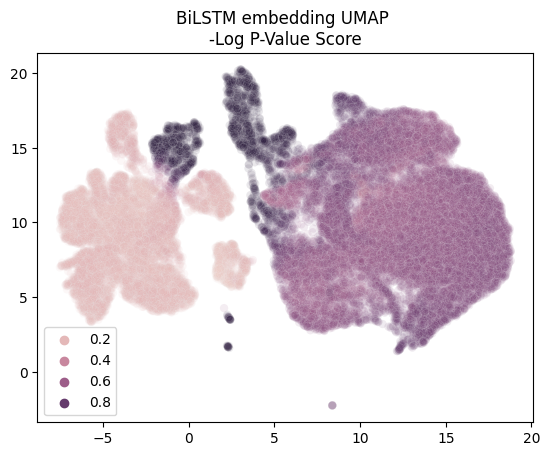

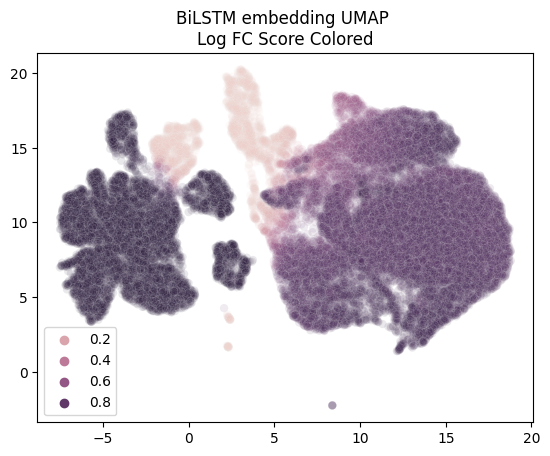

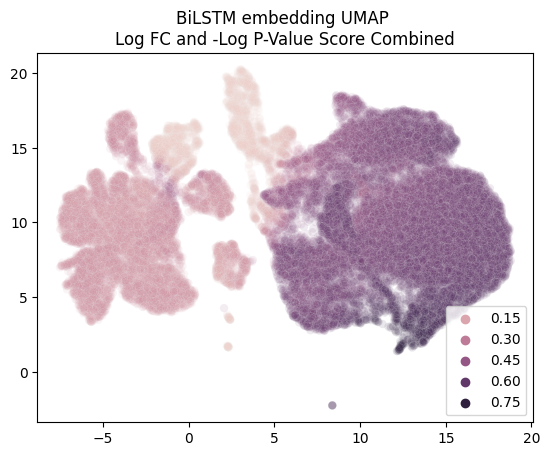

In [17]:
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0],
    title="BiLSTM embedding UMAP \n-Log P-Value Score",
)
plt.show()
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 1],
    title="BiLSTM embedding UMAP \nLog FC Score Colored",
)
plt.show()
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 1] * mdm2_model(X)[:, 0],
    title="BiLSTM embedding UMAP \nLog FC and -Log P-Value Score Combined",
)
plt.show()

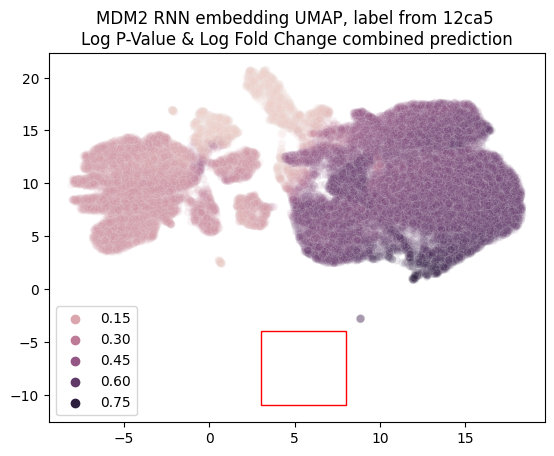

In [9]:
import matplotlib

ca5_coordinate = (3, -11)
ca5_width, ca5_height = 5, 7
ca5_rect = matplotlib.patches.Rectangle(
    ca5_coordinate, ca5_width, ca5_height, linewidth=1, edgecolor="r", facecolor="none"
)

umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from 12ca5 \nLog P-Value & Log Fold Change combined prediction",
    rectangle=ca5_rect,
)


In [10]:
def sample_in_bounds(emb, coor, w, h):
    return (emb[0] >= coor[0] and emb[0] <= (coor[0] + w)) and (
        emb[1] >= coor[1] and emb[1] <= (coor[1] + h)
    )


in_12ca5_cluster_peptides = [
    pep
    for idx, pep in enumerate(peptides)
    if sample_in_bounds(embedding[idx], coor=ca5_coordinate, w=ca5_width, h=ca5_height)
]
print('We have this many peptides in bounds for 12ca5:', len(in_12ca5_cluster_peptides))



We have this many peptides in bounds for 12ca5: 0


In [11]:
heatmap.generate_heatmap(
    in_12ca5_cluster_peptides, title="Heatmap of Model Generated UMAP 12ca5 Cluster"
)

save_web_logo_alignment(
    web_logo_name=None,
    seqs=heatmap.filter_to_nmers(in_12ca5_cluster_peptides, nmer_len=9),
    align=False,
    axis=None,
    to_type="information",
    title='Weblogo of filtered nine-mers in bound'
)
save_web_logo_alignment(
    web_logo_name=None,
    seqs=in_12ca5_cluster_peptides,
    align=True,
    axis=None,
    to_type="information",
    title='Weblogo of all libraries in bound'
)

/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/analysis/heatmap_analysis.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  seq9_s = pd.Series(ninemer_seq)


AttributeError: Can only use .str accessor with string values!

In [ ]:
ninemer_seq = []
for seq in in_12ca5_cluster_peptides:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in in_12ca5_cluster_peptides]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('GDY', 672)
('DYA', 648)
('YAC', 383)
('AAC', 155)
('YAA', 153)


## MDM2 Heatmaps from UMAP Cluster

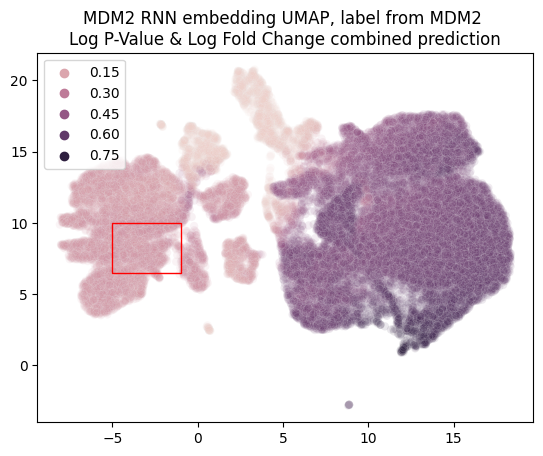

In [15]:
import matplotlib

mdm2_coordinate = (-5, 6.5)
mdm2_width, mdm2_height = 4, 3.5
rect = matplotlib.patches.Rectangle(
    mdm2_coordinate, mdm2_width, mdm2_height, linewidth=1, edgecolor="r", facecolor="none"
)

umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from MDM2 \nLog P-Value & Log Fold Change combined prediction",
    rectangle=rect,
)


In [14]:
in_mdm2_cluster_peptides = [
    pep
    for idx, pep in enumerate(peptides)
    if sample_in_bounds(
        embedding[idx], coor=mdm2_coordinate, w=mdm2_width, h=mdm2_height
    )
]
print('cluster size: ', len(in_mdm2_cluster_peptides))
heatmap.generate_heatmap(
    in_mdm2_cluster_peptides, title="Heatmap of Model Generated UMAP MDM2 Cluster"
)
save_web_logo_alignment(
    web_logo_name=None,
    seqs=heatmap.filter_to_nmers(in_mdm2_cluster_peptides, nmer_len=9),
    align=False,
    axis=None,
    to_type="information",
    title='Weblogo of filtered nine-mers in bound'
)
save_web_logo_alignment(
    web_logo_name=None,
    seqs=in_mdm2_cluster_peptides,
    align=True,
    axis=None,
    to_type="information",
    title='Weblogo of all libraries in bound'
)

NameError: name 'mdm2_coordinate' is not defined

In [13]:
import matplotlib


def draw_peptides_from_umap(
    coordinate=(-5, 6.5),
    width=4,
    height=3.5,
    title="Heatmap of Model Generated UMAP - Low Pvalue / high FC cluster",
):
    rect = matplotlib.patches.Rectangle(
        coordinate, width, height, linewidth=1, edgecolor="r", facecolor="none"
    )

    umap.UMAP_vis(
        embedding,
        mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
        title="MDM2 RNN embedding UMAP, label from MDM2 \nLog P-Value & Log Fold Change combined prediction",
        rectangle=rect,
    )
    plt.show()
    in_mdm2_cluster_peptides = [
        pep
        for idx, pep in enumerate(peptides)
        if sample_in_bounds(embedding[idx], coor=coordinate, w=width, h=height)
    ]
    print("cluster size: ", len(in_mdm2_cluster_peptides))
    # heatmap.generate_heatmap(in_mdm2_cluster_peptides, title=title)
    save_web_logo_alignment(
        web_logo_name=None,
        seqs=heatmap.filter_to_nmers(in_mdm2_cluster_peptides, nmer_len=9),
        align=False,
        axis=None,
        to_type="information",
        title=title + "\nWeblogo of filtered nine-mers in bound",
    )
    save_web_logo_alignment(
        web_logo_name=None,
        seqs=in_mdm2_cluster_peptides,
        align=True,
        axis=None,
        to_type="information",
        title=title + "\nWeblogo of all libraries in bound",
    )


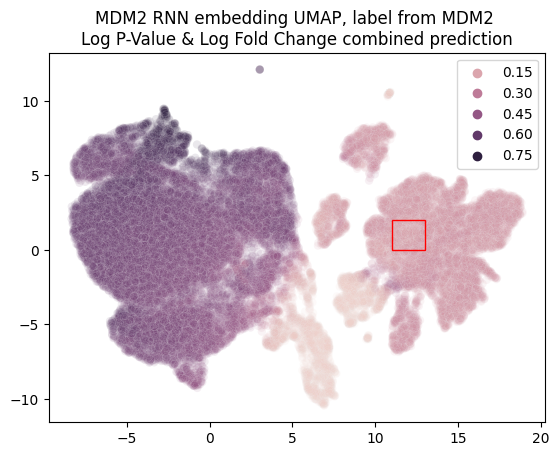

cluster size:  618


LogomakerError: sequences must have length > 0.

In [ ]:
draw_peptides_from_umap(coordinate=(11, 0), height=2, width=2, title="Heatmap of Model Generated UMAP - Low Pvalue / high FC cluster")


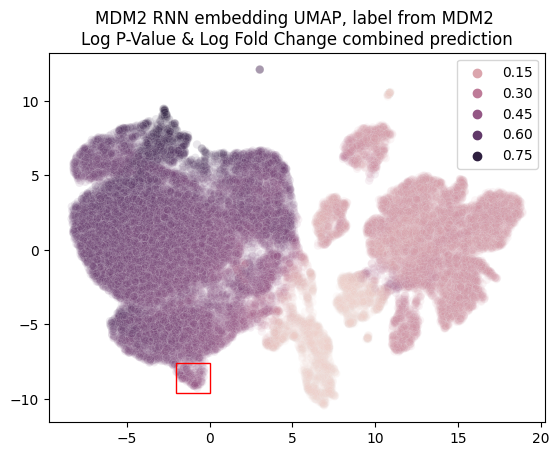

cluster size:  188


/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


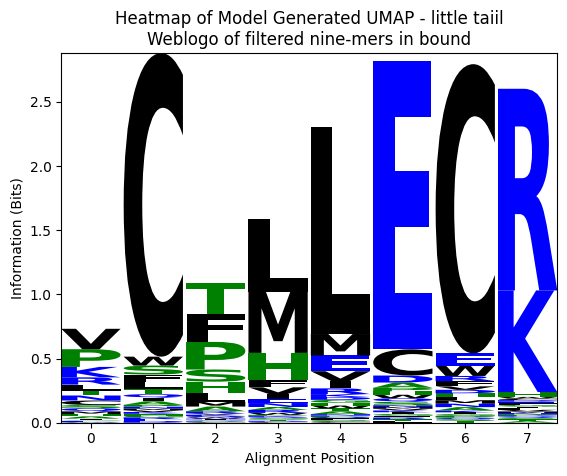


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 188 seqs, max length 9, avg  length 9
00:00:00      2 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      2 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      4 MB(0%)  Iter   1  100.00%  Align node       
00:00:00      4 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


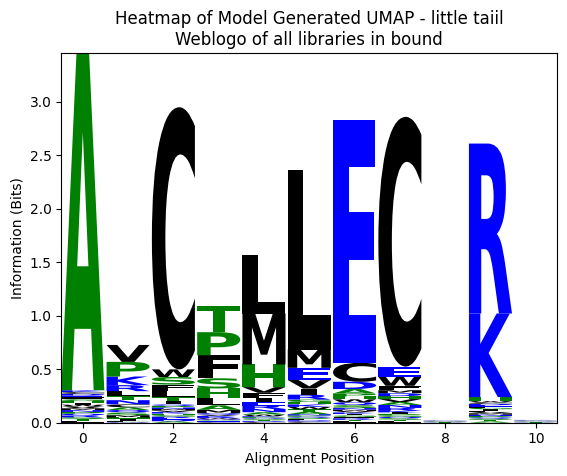

In [ ]:
draw_peptides_from_umap(coordinate=(-2, -9.6), height=2, width=2, title="Heatmap of Model Generated UMAP - little taiil")


In [12]:
draw_peptides_from_umap(coordinate=(-2, 0), height=2, width=2, title="Heatmap of Model Generated UMAP - Big continent")


NameError: name 'draw_peptides_from_umap' is not defined

## 12ca5 Heatmaps from Model Ranking

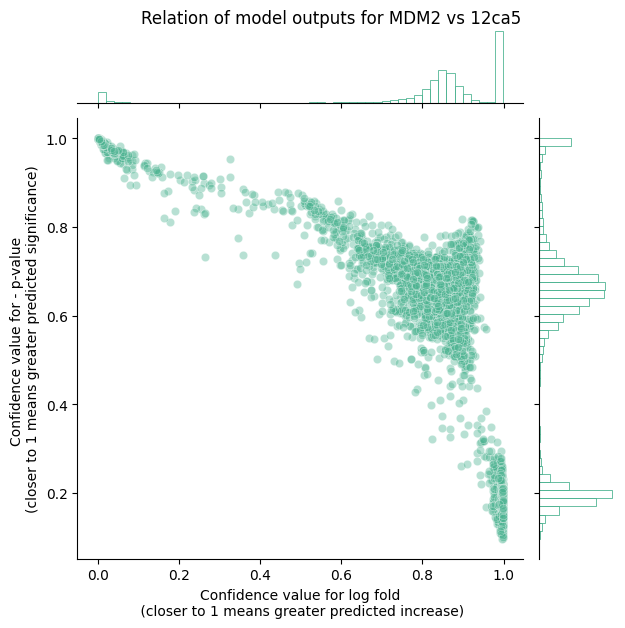

In [ ]:
import matplotlib.pyplot as plt
import matplotlib


def show_volcano(y, protein_of_interest, other_protein, title, x_label, y_label):
    sns.set_palette(sns.color_palette("plasma"))
    p = sns.jointplot(
        x=y[:, 1],
        y=y[:, 0],
        color="#4CB391",
        alpha=0.4,
        marginal_kws=dict(bins=50, fill=False),
    )  
    p.fig.suptitle(title)
    p.set_axis_labels(x_label, y_label)
    p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 



show_volcano(
    mdm2_model(X_test),
    protein_of_interest,
    other_protein,
    title=f"Relation of model outputs for {protein_of_interest} vs {other_protein}",
    x_label="Confidence value for log fold\n (closer to 1 means greater predicted increase)",
    y_label="Confidence value for - p-value \n(closer to 1 means greater predicted significance)",
)



MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 500 seqs, max length 9, avg  length 8
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      9 MB(0%)  Iter   1  100.00%  Align node       
00:00:00      9 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


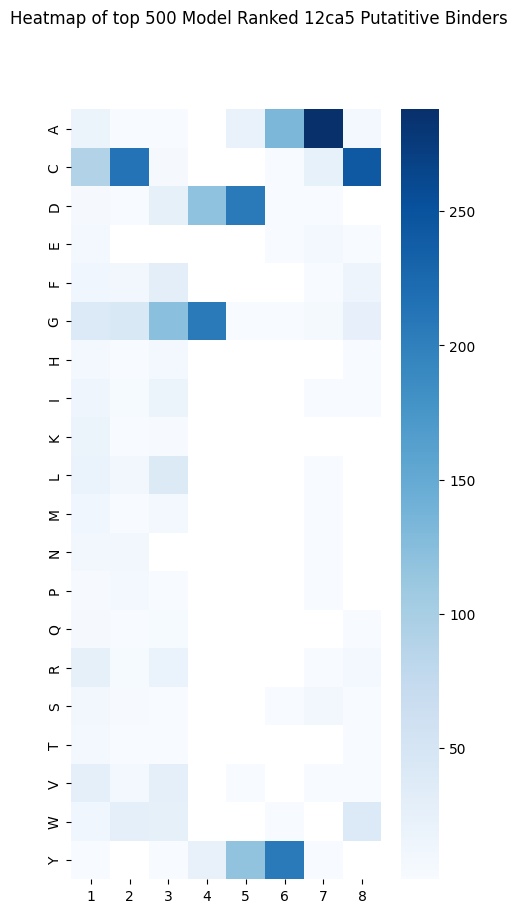

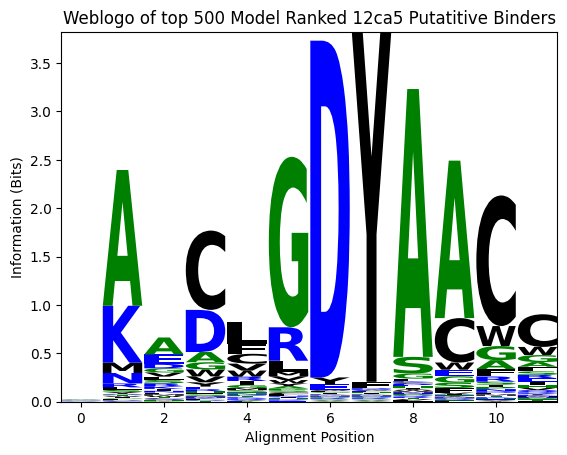


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 500 seqs, max length 9, avg  length 8
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      9 MB(0%)  Iter   1  100.00%  Align node       
00:00:00      9 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


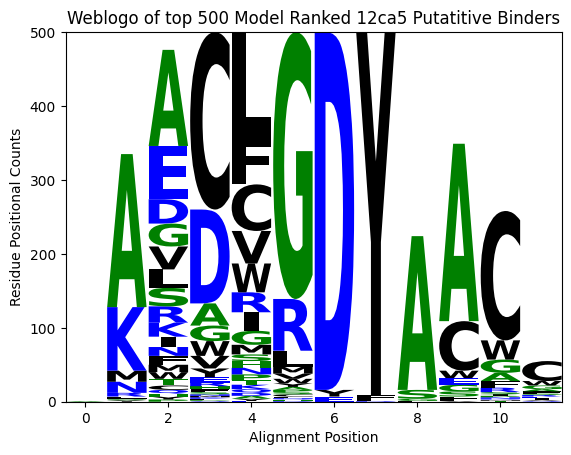

In [19]:
from analysis.hit_rate_analysis import sort_peptides_by_model_ranking

sorted_ca5_peptides = sort_peptides_by_model_ranking(
    peptides, ca5_model(X)
)
heatmap.generate_heatmap(
    sorted_ca5_peptides[:500], title="Heatmap of top 500 Model Ranked 12ca5 Putatitive Binders"
)
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_ca5_peptides[:500],
    align=True,
    axis=None,
    to_type="information",
    title='Weblogo of top 500 Model Ranked 12ca5 Putatitive Binders'
)
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_ca5_peptides[:500],
    align=True,
    axis=None,
    to_type="counts",
    title='Weblogo of top 500 Model Ranked 12ca5 Putatitive Binders'
)

/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


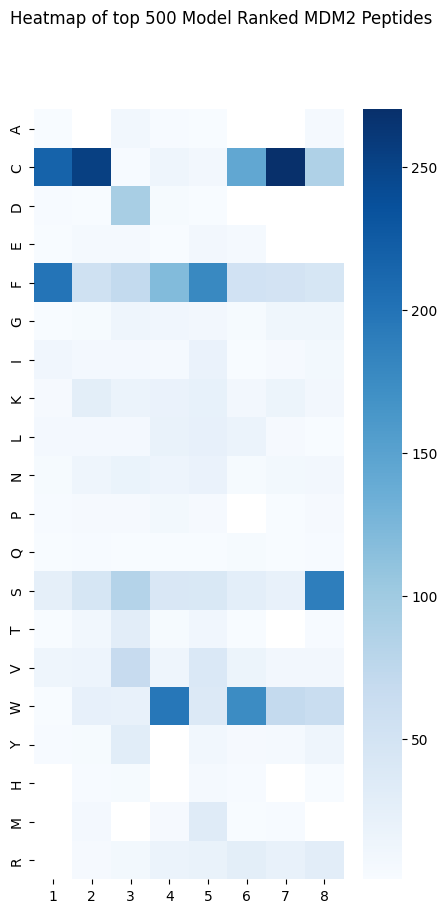

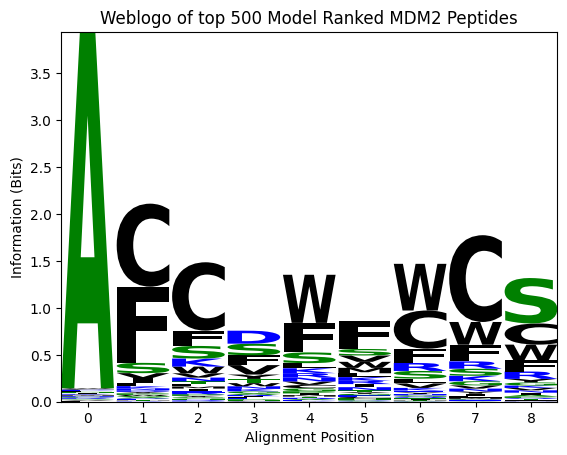

/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


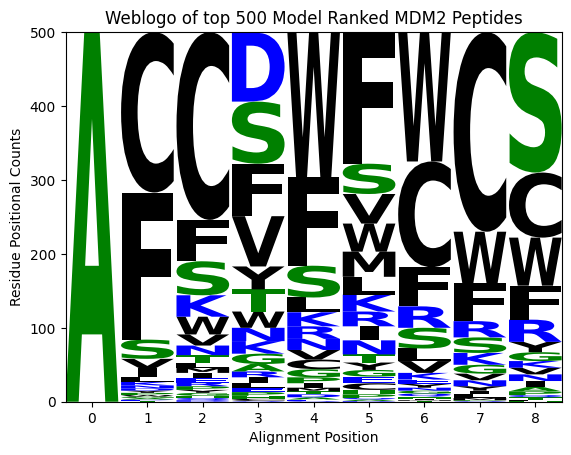

In [18]:
from analysis.hit_rate_analysis import sort_peptides_by_model_ranking
from analysis.create_weblogos import save_web_logo_alignment

sorted_mdm2_peptides = sort_peptides_by_model_ranking(peptides, mdm2_model(X))
heatmap.generate_heatmap(
    sorted_mdm2_peptides[:500], title="Heatmap of top 500 Model Ranked MDM2 Peptides"
)
fig, ax1 = plt.subplots()
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_mdm2_peptides[:500],
    align=False,
    axis=ax1,
    to_type="information",
    title="Weblogo of top 500 Model Ranked MDM2 Peptides"
)
fig, ax2 = plt.subplots()
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_mdm2_peptides[:500],
    align=False,
    axis=ax2,
    to_type="counts",
    title="Weblogo of top 500 Model Ranked MDM2 Peptides"
)



MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 500 seqs, max length 10, avg  length 8
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      9 MB(0%)  Iter   1  100.00%  Align node       
00:00:00      9 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


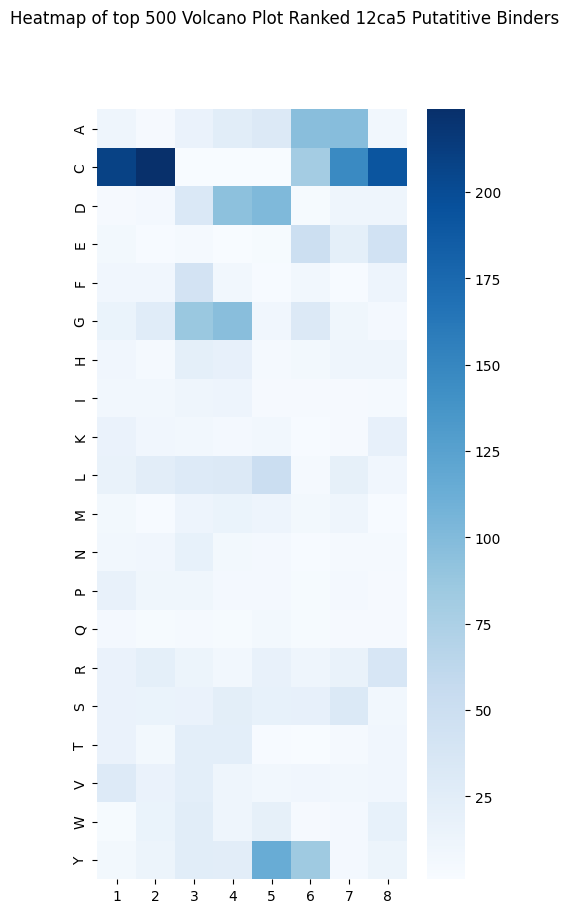

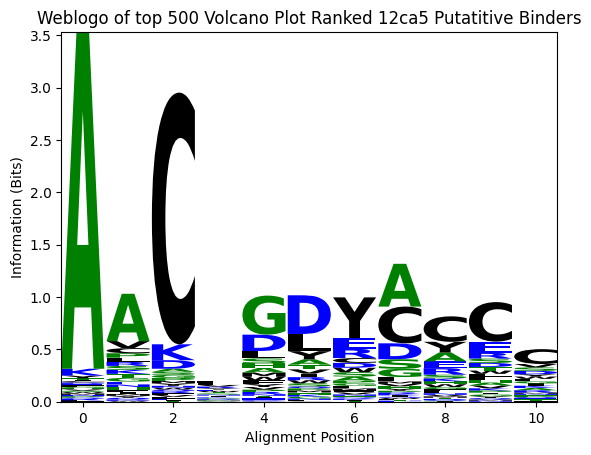


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 500 seqs, max length 10, avg  length 8
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      9 MB(0%)  Iter   1  100.00%  Align node       
00:00:00      9 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


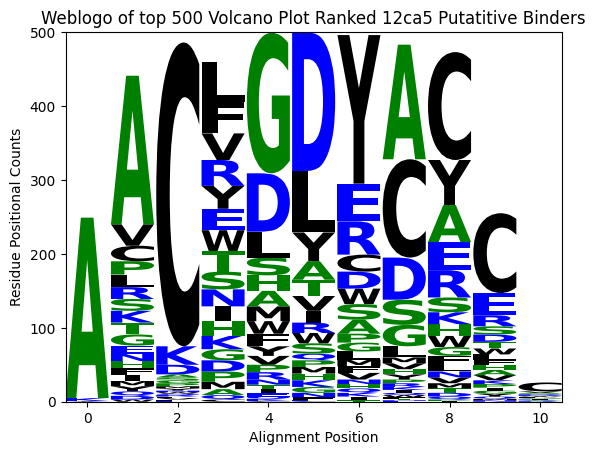

In [20]:
from analysis.hit_rate_analysis import sort_peptides_by_model_ranking

sorted_ca5_peptides = sort_peptides_by_model_ranking(
    peptides, mdm2_y_raw * [1,-1]
)
heatmap.generate_heatmap(
    sorted_ca5_peptides[:500], title="Heatmap of top 500 Volcano Plot Ranked 12ca5 Putatitive Binders"
)
fig, ax1 = plt.subplots()
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_ca5_peptides[:500],
    align=True,
    axis=ax1,
    to_type="information",
    title='Weblogo of top 500 Volcano Plot Ranked 12ca5 Putatitive Binders'
)
fig, ax1 = plt.subplots()
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_ca5_peptides[:500],
    align=True,
    axis=ax1,
    to_type="counts",
    title='Weblogo of top 500 Volcano Plot Ranked 12ca5 Putatitive Binders'
)


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 500 seqs, max length 12, avg  length 8
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00     10 MB(0%)  Iter   1  100.00%  Align node       
00:00:00     10 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


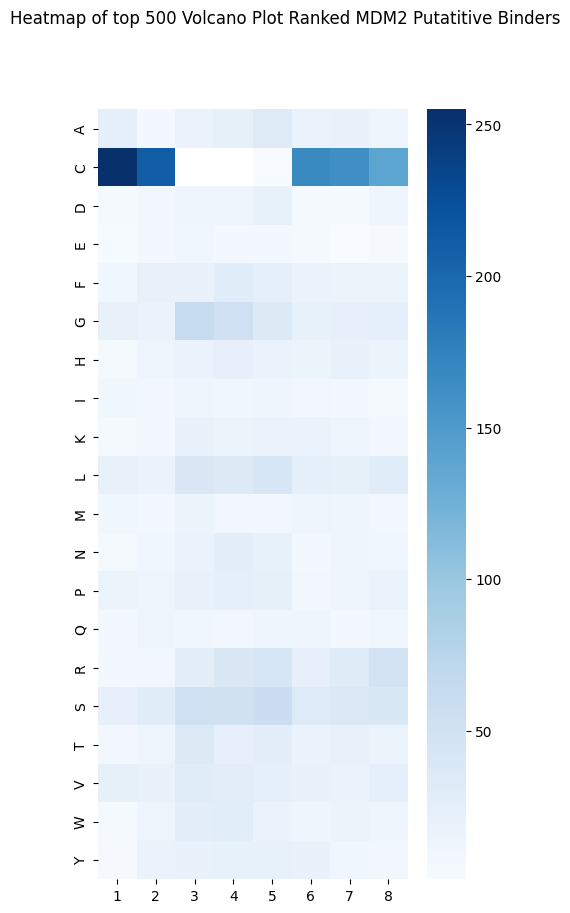

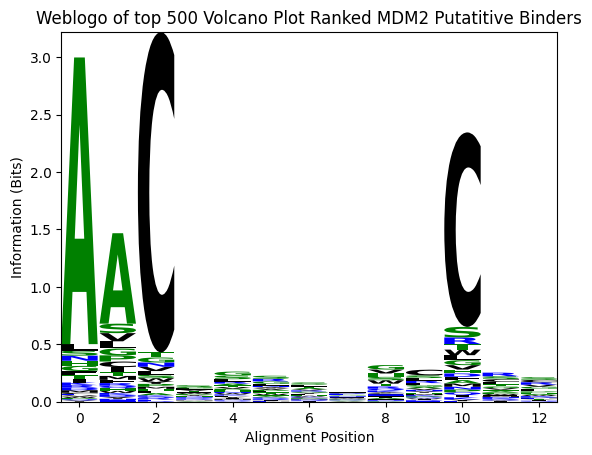


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 500 seqs, max length 12, avg  length 8
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00     10 MB(0%)  Iter   1  100.00%  Align node       
00:00:00     10 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


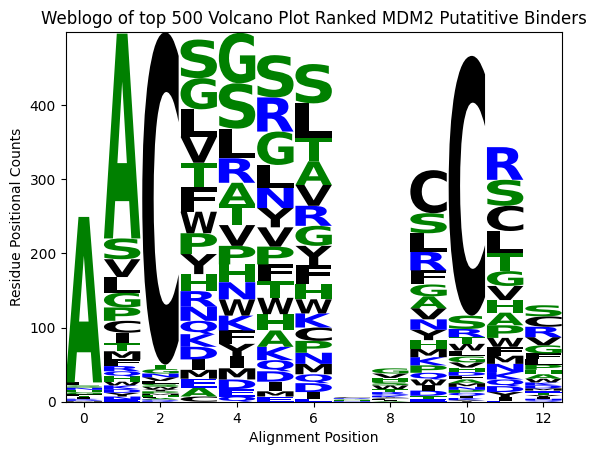

In [21]:
from analysis.hit_rate_analysis import sort_peptides_by_model_ranking

sorted_mdm2_peptides = sort_peptides_by_model_ranking(
    peptides, mdm2_y_raw
)
heatmap.generate_heatmap(
    sorted_mdm2_peptides[:500], title="Heatmap of top 500 Volcano Plot Ranked MDM2 Putatitive Binders"
)
fig, ax1 = plt.subplots()
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_mdm2_peptides[:500],
    align=True,
    axis=ax1,
    to_type="information",
    title='Weblogo of top 500 Volcano Plot Ranked MDM2 Putatitive Binders'
)
fig, ax2 = plt.subplots()
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_mdm2_peptides[:500],
    align=True,
    axis=ax2,
    to_type="counts",
    title='Weblogo of top 500 Volcano Plot Ranked MDM2 Putatitive Binders'
)